In [ ]:
!pip install kmodes --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.stats import mode
import warnings

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### K-Means Clustering

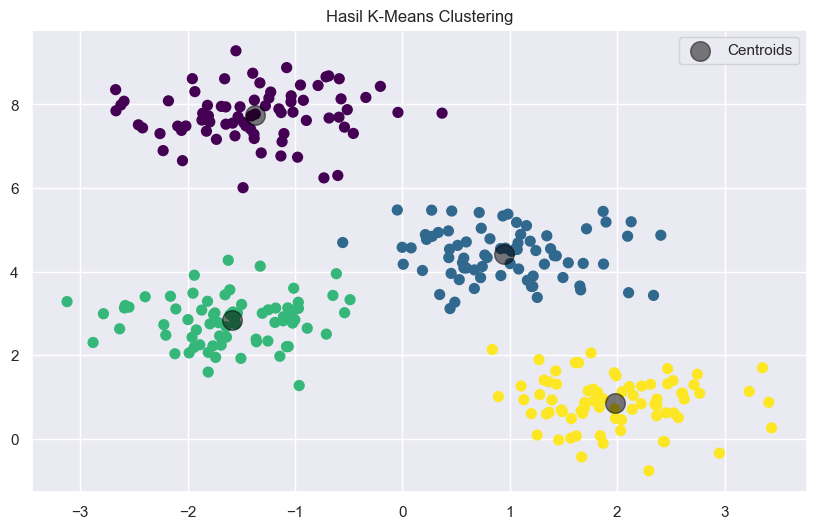

In [21]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

# 1. Generate Data Dummy
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)

# 2. Menjalankan K-Means
kmeans = KMeans(n_clusters=4) 
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

# 3. Visualisasi Hasil Clustering
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

# Plot sentroid
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5, label='Centroids')
plt.title("Hasil K-Means Clustering")
plt.legend()
plt.show()

### Implementasi K-Means Manual (Expectation-Maximization)

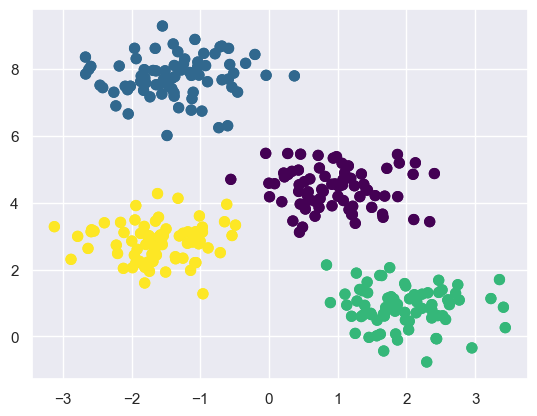

In [23]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters (Inisialisasi sentroid acak)
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]

    while True:
        # 2a. E-Step: Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)

        # 2b. M-Step: Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])

        # 2c. Check for convergence (Berhenti jika sentroid tidak berubah)
        if np.all(centers == new_centers):
            break
        centers = new_centers

    return centers, labels

# Menjalankan fungsi manual tersebut
centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')
plt.show()

### Caveats of Expectation-Maximization 

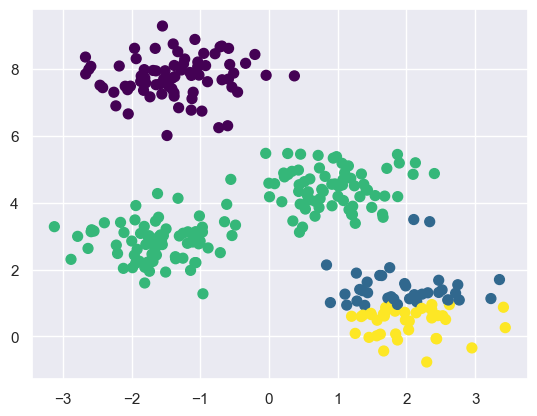

In [33]:
centers, labels = find_clusters(X, 4, rseed=0)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')
plt.show()

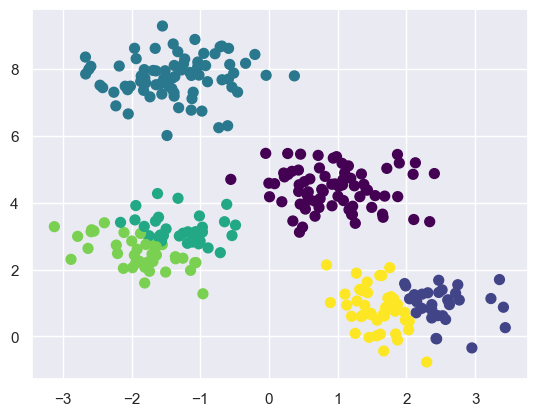

In [34]:
labels = KMeans(6, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')
plt.show()

### Batasan K-Means & Solusi (Spectral Clustering)

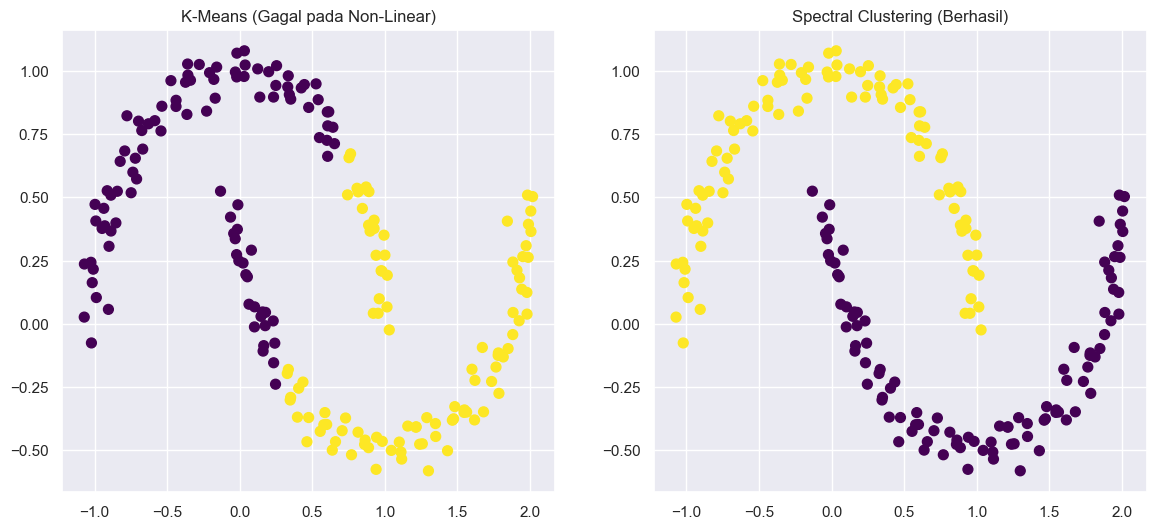

In [6]:
from sklearn.datasets import make_moons
from sklearn.cluster import SpectralClustering

# 1. Generate Data Half-Moons (Data non-linear)
X_moon, y_moon = make_moons(200, noise=.05, random_state=0)

# 2. Coba dengan K-Means Biasa (Gagal memisahkan bentuk bulan sabit)
labels_kmeans = KMeans(2, random_state=0, n_init=10).fit_predict(X_moon)

# 3. Coba dengan Spectral Clustering Menggunakan nearest_neighbors affinity
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels_spectral = model.fit_predict(X_moon)

# 4. Visualisasi Perbandingan
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].scatter(X_moon[:, 0], X_moon[:, 1], c=labels_kmeans, s=50, cmap='viridis')
ax[0].set_title("K-Means (Gagal pada Non-Linear)")

ax[1].scatter(X_moon[:, 0], X_moon[:, 1], c=labels_spectral, s=50, cmap='viridis')
ax[1].set_title("Spectral Clustering (Berhasil)")

plt.show()

### Studi Kasus 1 - K-Means pada Digit Tulisan Tangan

Shape data digits: (1797, 64)


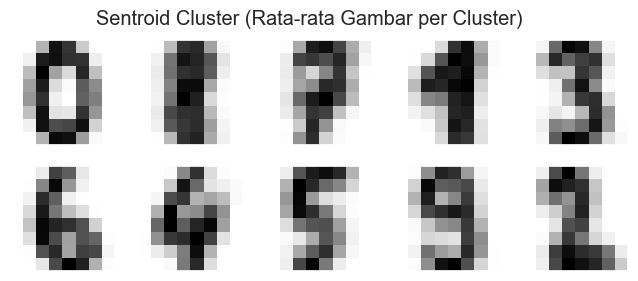


Akurasi K-Means pada Digits: 0.79 (Tanpa label saat training!)


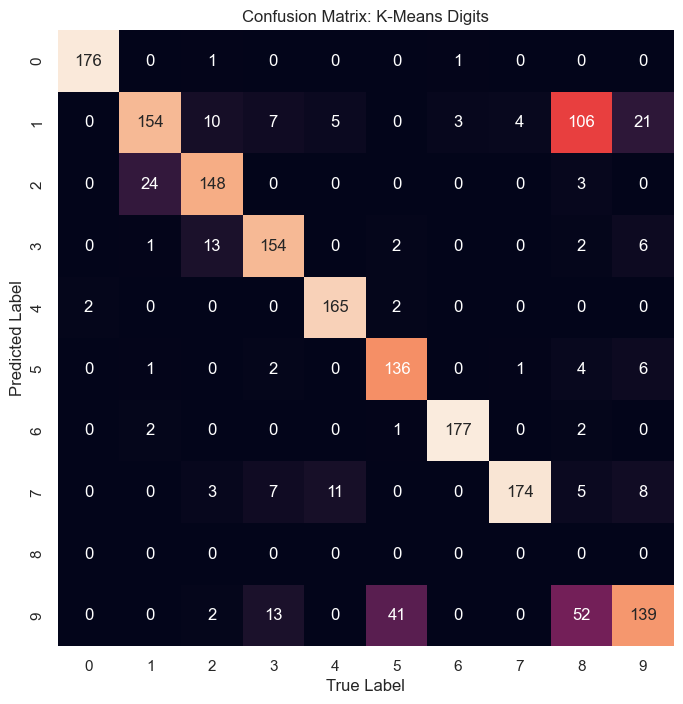

In [7]:
from sklearn.datasets import load_digits

# 1. Load Dataset Digits
digits = load_digits()
print(f"Shape data digits: {digits.data.shape}") # (1797, 64)

# 2. Jalankan K-Means (10 Cluster untuk angka 0-9)
kmeans_digits = KMeans(n_clusters=10, random_state=0, n_init=10)
clusters = kmeans_digits.fit_predict(digits.data)

# 3. Visualisasi Sentroid Cluster (Bentuk angka rata-rata)
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans_digits.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)
plt.suptitle("Sentroid Cluster (Rata-rata Gambar per Cluster)")
plt.show()

# 4. Mencocokkan Label Cluster dengan Label Asli
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    # Menggunakan mode statistik untuk menetapkan label
    labels[mask] = mode(digits.target[mask], keepdims=True)[0][0]

# 5. Evaluasi Akurasi & Confusion Matrix
acc = accuracy_score(digits.target, labels)
print(f"\nAkurasi K-Means pada Digits: {acc:.2f} (Tanpa label saat training!)")

mat = confusion_matrix(digits.target, labels)
plt.figure(figsize=(8, 8))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.title("Confusion Matrix: K-Means Digits")
plt.show()

### Studi Kasus 2 - Kompresi Warna Gambar (Color Quantization)

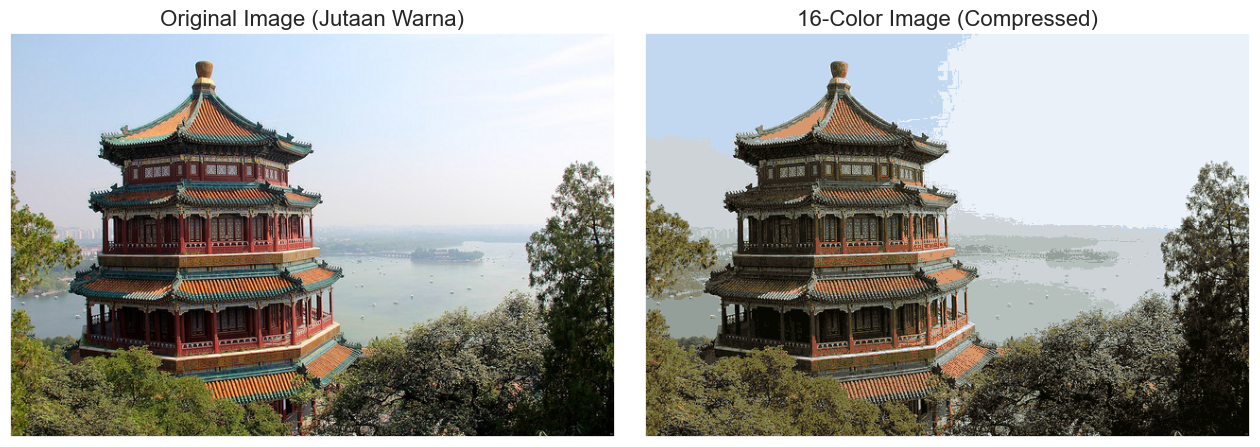

In [51]:
from sklearn.datasets import load_sample_image
from sklearn.cluster import MiniBatchKMeans

# 1. Load Gambar Sampel
china = load_sample_image("china.jpg")
# Normalisasi nilai pixel ke range 0-1
data = china / 255.0
data = data.reshape(427 * 640, 3) # Reshape ke array 2D (pixel, RGB)

# 2. Kompresi Warna dengan MiniBatchKMeans menjadi 16(Lebih cepat untuk data besar)
kmeans = MiniBatchKMeans(16, n_init=3)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

# 3. Reshape kembali ke dimensi gambar asli
china_recolored = new_colors.reshape(china.shape)

# 4. Visualisasi Perbandingan
fig, ax = plt.subplots(1, 2, figsize=(16, 6), subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)

ax[0].imshow(china)
ax[0].set_title('Original Image (Jutaan Warna)', size=16)

ax[1].imshow(china_recolored)
ax[1].set_title('16-Color Image (Compressed)', size=16)

plt.show()

In [37]:
print(china.shape)
print(data.shape)

(427, 640, 3)
(273280, 3)


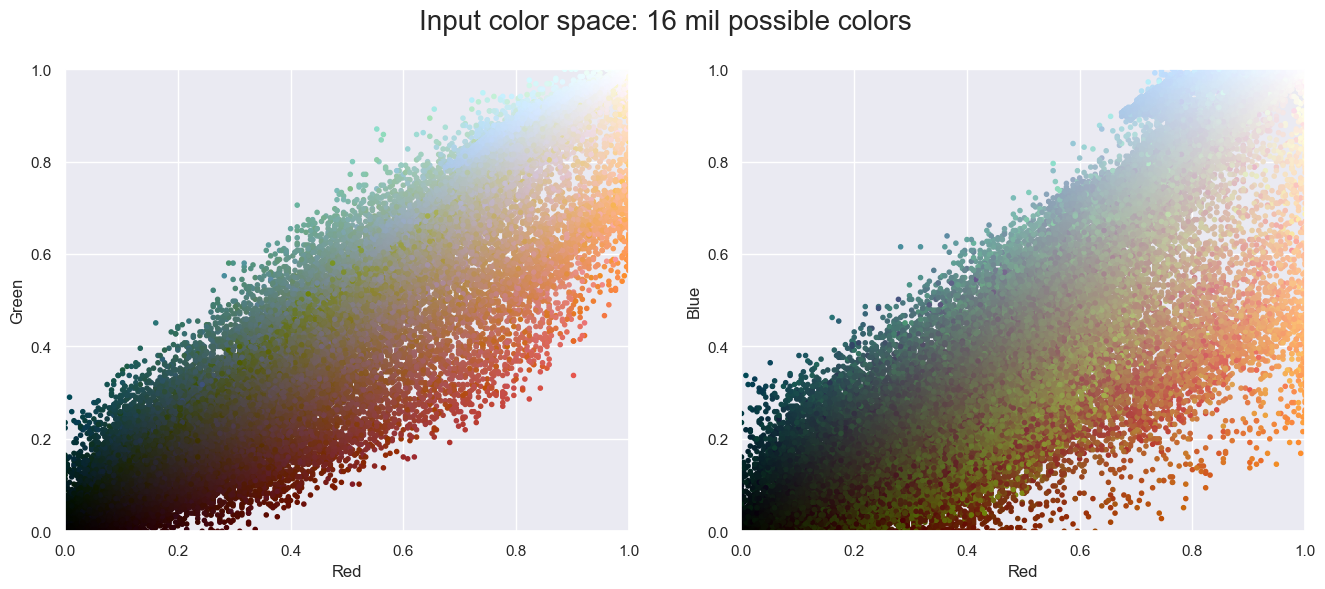

In [48]:
def plot_pixels(data, title, colors=None, N=100000):
    if colors is None:
        colors=data
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color= colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0,1), ylim=(0, 1))
    
    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0,1), ylim=(0,1))
    
    fig.suptitle(title, size=20)
    
plot_pixels(data, title='Input color space: 16 mil possible colors')
plt.show()

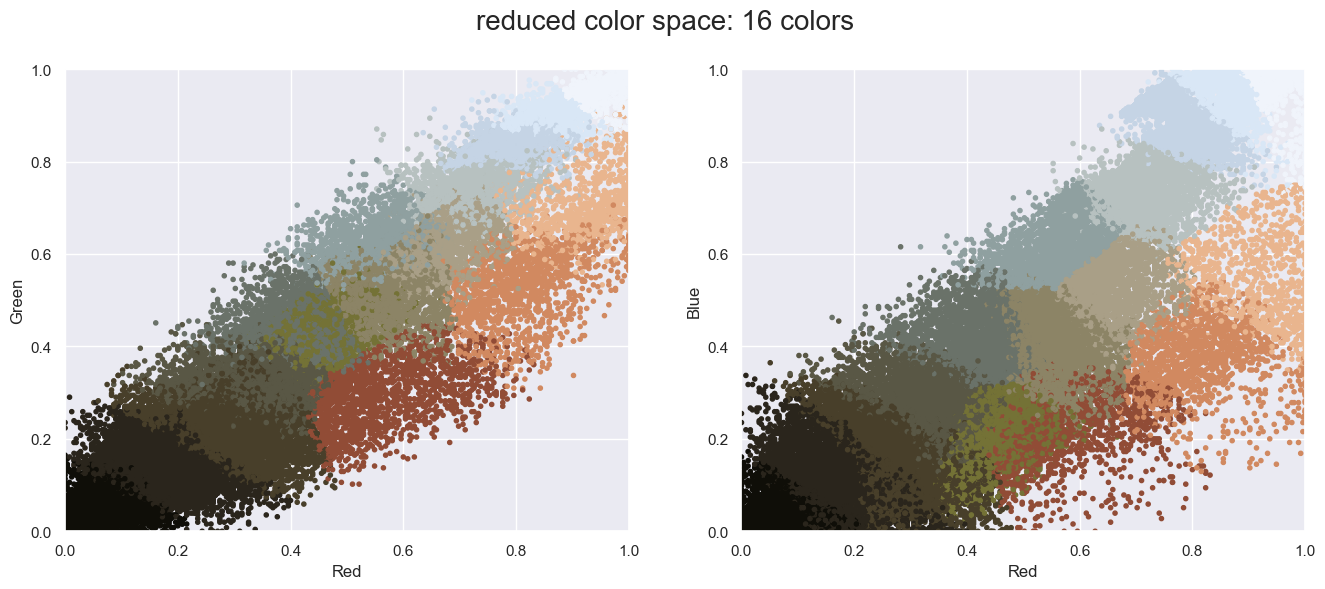

In [49]:
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors, title="reduced color space: 16 colors")
plt.show()

### K-Medoids (Implementasi Manual Lengkap)

<bound method NDFrame.head of      sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0             0.222222          0.625000           0.067797          0.041667
1             0.166667          0.416667           0.067797          0.041667
2             0.111111          0.500000           0.050847          0.041667
3             0.083333          0.458333           0.084746          0.041667
4             0.194444          0.666667           0.067797          0.041667
..                 ...               ...                ...               ...
145           0.666667          0.416667           0.711864          0.916667
146           0.555556          0.208333           0.677966          0.750000
147           0.611111          0.416667           0.711864          0.791667
148           0.527778          0.583333           0.745763          0.916667
149           0.444444          0.416667           0.694915          0.708333

[150 rows x 4 columns]>
(150, 3)


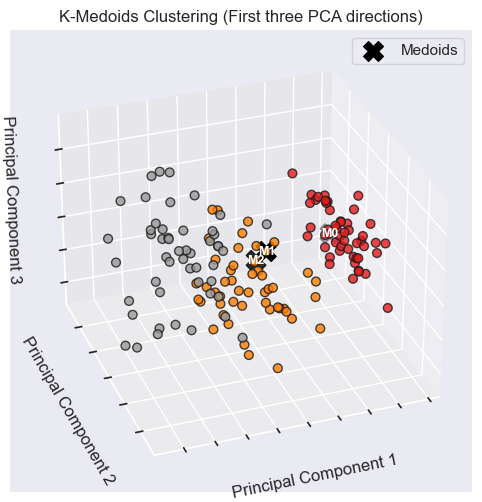

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# --- 1. Persiapan Data (Iris) ---
# Load dataset [cite: 99]
iris = datasets.load_iris()
data = pd.DataFrame(iris.data, columns=iris.feature_names)
target = iris.target_names
labels = iris.target

# Scaling Data [cite: 100-102]
scaler = MinMaxScaler()
data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
print(data.head)

# PCA Transformation (4 Dimensi -> 3 Dimensi)
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(data)
PCAdf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
datapoints = PCAdf.values
m, f = datapoints.shape
k = 3
print(datapoints.shape)

# --- 2. Visualisasi 3D ---
# Plotting hasil dalam 3 Dimensi sesuai materi [cite: 107]
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
X_reduced = datapoints

# Plot data points
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], 
           c=labels, cmap=plt.cm.Set1, edgecolor='k', s=40)

# Ensure a 3D axes is attached to the figure (some backends may leave fig with 0 axes)
if not fig.get_axes():
    ax = fig.add_subplot(111, projection='3d')
else:
    ax = fig.get_axes()[0]
    if getattr(ax, 'name', '') != '3d':
        fig.clf()
        ax = fig.add_subplot(111, projection='3d')

# Re-plot the PCA points (use existing X_reduced and labels)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2],
           c=labels, cmap=plt.cm.Set1, edgecolor='k', s=40, alpha=0.8)

# Plot medoids if available
if 'final_medoids' in globals() and final_medoids is not None:
    ax.scatter(final_medoids[:, 0], final_medoids[:, 1], final_medoids[:, 2],
               c='black', marker='X', s=200, label='Medoids')
    for idx, m in enumerate(final_medoids):
        ax.text(m[0], m[1], m[2], f'M{idx}', color='white', ha='center', va='center',
                fontsize=9, weight='bold')

ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
ax.set_xticklabels([]); ax.set_yticklabels([]); ax.set_zticklabels([])
ax.view_init(elev=-150, azim=110)
ax.set_title("K-Medoids Clustering (First three PCA directions)")
ax.legend()
plt.show()

In [71]:
# --- Definisi Fungsi K-Medoids ---

def init_medoids(X, k):
    from numpy.random import seed, choice
    seed(1)
    samples = choice(len(X), size=k, replace=False)
    return X[samples, :]
medoids_initial = init_medoids(datapoints, 3)
print(medoids_initial,"\n")

def compute_d_p(X, medoids, p):
    m = len(X)
    medoids_shape = medoids.shape
    if len(medoids_shape) == 1:
        medoids = medoids.reshape((1, len(medoids)))
    k = len(medoids)
    
    S = np.empty((m, k))
    
    for i in range(m):
        # Menghitung jarak ke setiap medoid
        d_i = np.linalg.norm(X[i, :] - medoids, ord=p, axis=1)
        S[i, :] = d_i**p # Minkowski distance power p
        
    return S
S = compute_d_p(datapoints, medoids_initial, 2)
print("\n\n",S)

def assign_labels(S):
    return np.argmin(S, axis=1)
labels = assign_labels(S)
print("\n", labels)

def update_medoids(X, medoids, p):
    S = compute_d_p(X, medoids, p)
    labels = assign_labels(S)
    
    out_medoids = medoids.copy()
    
    # Iterasi setiap cluster
    for i in set(labels):
        # Hitung total dissimilarity medoid saat ini
        avg_dissimilarity = np.sum(compute_d_p(X, medoids[i].reshape(1, -1), p))
        
        # Ambil semua titik dalam cluster i
        cluster_points = X[labels == i]
        
        for datap in cluster_points:
            # Hitung dissimilarity jika titik ini jadi medoid baru
            new_dissimilarity = np.sum(compute_d_p(X, datap.reshape(1, -1), p))
            
            # Jika lebih baik, update medoid
            if new_dissimilarity < avg_dissimilarity:
                avg_dissimilarity = new_dissimilarity
                out_medoids[i] = datap
                
    return out_medoids

def has_converged(old_medoids, medoids):
    return set([tuple(x) for x in old_medoids]) == set([tuple(x) for x in medoids])

def kmedoids(X, k, p, starting_medoids=None, max_steps=np.inf):
    if starting_medoids is None:
        medoids = init_medoids(X, k)
    else:
        medoids = starting_medoids
        
    converged = False
    labels = np.zeros(len(X))
    i = 1
    
    while (not converged) and (i <= max_steps):
        old_medoids = medoids.copy()
        
        S = compute_d_p(X, medoids, p)
        labels = assign_labels(S)
        medoids = update_medoids(X, medoids, p)
        
        converged = has_converged(old_medoids, medoids)
        i += 1
        
    return (medoids, labels)

results = kmedoids(datapoints, 3, 2)
final_medoids = results[0]
data['clusters'] = results[1]

# --- Eksekusi Algoritma ---
# Menjalankan K-Medoids dengan k=3 dan p=2 (Euclidean distance squared logic)
final_medoids, result_labels = kmedoids(datapoints, k=3, p=2)
print("Medoid Akhir:\n", final_medoids)

# --- 4. Evaluasi Akurasi (Permutasi Label) ---
# Fungsi ini diperlukan karena label cluster (0,1,2) mungkin tertukar posisinya 
# dengan label asli iris (misal cluster 0 sebenarnya adalah spesies 2)
def mark_matches(a, b, exact=False):
    assert a.shape == b.shape
    a_int = a.astype(dtype=int)
    b_int = b.astype(dtype=int)
    all_axes = tuple(range(len(a.shape)))
    assert((a_int==0)|(a_int==1)|(a_int==2)).all()
    assert((b_int==0)|(b_int==1)|(b_int==2)).all()
    exact_matches = (a_int == b_int)
    if exact:
        return exact_matches
    assert exact == False
    num_exact_matches = np.sum(exact_matches)
    if(2*num_exact_matches)>=np.prod(a.shape):
        return exact_matches
    return exact_matches == False

def count_matches(a, b, exact=False):
    matches = mark_matches(a, b, exact=exact)
    return np.sum(matches)
n_matches = count_matches(labels, data['clusters'])
print(n_matches, "matches out of", len(data), "data points", "(~ {:.1f}%)".format(100.0*n_matches/len(labels)))

[[-0.60037159  0.38024069  0.08516953]
 [-0.15863457 -0.28913985 -0.0524159 ]
 [ 0.21396272  0.059963    0.11409813]] 



 [[0.07968064 0.3852937  0.7248244 ]
 [0.23654649 0.26004161 0.73153592]
 [0.20209589 0.31859043 0.81083493]
 [0.2480507  0.28108167 0.79899978]
 [0.07328835 0.42025569 0.76644093]
 [0.02468474 0.47754216 0.6335645 ]
 [0.17102739 0.33938008 0.80260393]
 [0.11010499 0.34254533 0.71519075]
 [0.35783221 0.27539032 0.88186121]
 [0.20281054 0.29945624 0.75784222]
 [0.02775562 0.45960533 0.68697806]
 [0.13436964 0.33499155 0.74740623]
 [0.2505374  0.29459209 0.80097502]
 [0.3448417  0.36595003 1.01268223]
 [0.         0.66213165 0.76655503]
 [0.03579188 0.80211274 0.81744851]
 [0.02127369 0.51529454 0.70108133]
 [0.08302796 0.35731766 0.68556492]
 [0.01509555 0.47944961 0.59289047]
 [0.0437377  0.46409076 0.73404497]
 [0.0792879  0.33420167 0.59754411]
 [0.06094364 0.39785527 0.67347669]
 [0.13666818 0.48174381 0.95211424]
 [0.14542075 0.221955   0.53921336]
 [0.13435467 

### K-Modes - Persiapan Data (Bank Marketing)

In [84]:
# 1. Load Dataset
bank = pd.read_excel('bankmarketing.xlsx')
print(bank.head(), "\n\n")
print(bank.columns, "\n\n")

# Normalize column names to avoid KeyError due to spacing/case differences
bank.columns = (bank.columns
                .astype(str)
                .str.strip()
                .str.lower()
                .str.replace(' ', '_')
                .str.replace('-', '_'))

print("Normalized columns:\n", bank.columns, "\n\n")

# Target categorical columns (normalized names)
expected_cols = ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
                 'contact', 'month', 'day_of_week', 'poutcome']

# Keep only available columns and warn about missing ones
available_cols = [c for c in expected_cols if c in bank.columns]
missing_cols = [c for c in expected_cols if c not in bank.columns]
if missing_cols:
    print(f"Warning: these expected columns are missing and will be skipped: {missing_cols}")

if not available_cols:
    raise ValueError("No expected columns found in the dataset. Check the input file or column names.")

bank_cust = bank[available_cols].copy()

# 2. Feature Engineering: Binning Age (only if 'age' exists)
if 'age' in bank_cust.columns:
    bank_cust['age_bin'] = pd.cut(bank_cust['age'],
                                  bins=[0, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                                  labels=['0-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100'])
    bank_cust = bank_cust.drop('age', axis=1)
else:
    print("Column 'age' not found -> skipping age binning.")

# Simpan copy data asli untuk visualisasi nanti
bank_cust_copy = bank_cust.copy()

# 3. Label Encoding (Mengubah string jadi angka untuk algoritma)
# Use a fresh LabelEncoder per column and convert values to string to handle NaNs consistently
bank_cust_encoded = pd.DataFrame(index=bank_cust.index)
for col in bank_cust.columns:
    le_col = LabelEncoder()
    bank_cust_encoded = bank_cust.apply(le_col.fit_transform)
    bank_cust_encoded.head()
    
print("Data setelah encoding:")
print(bank_cust_encoded.head())

   age          job  marital  education default  balance housing loan  \
0   30   unemployed  married    primary      no     1787      no   no   
1   33     services  married  secondary      no     4789     yes  yes   
2   35   management   single   tertiary      no     1350     yes   no   
3   30   management  married   tertiary      no     1476     yes  yes   
4   59  blue-collar  married  secondary      no        0     yes   no   

    contact  day month  duration  campaign  pdays  previous poutcome   y  
0  cellular   19   oct        79         1     -1         0  unknown  no  
1  cellular   11   may       220         1    339         4  failure  no  
2  cellular   16   apr       185         1    330         1  failure  no  
3   unknown    3   jun       199         4     -1         0  unknown  no  
4   unknown    5   may       226         1     -1         0  unknown  no   


Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day

### K-Modes - Eksekusi & Analisis Cluster

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 453, cost: 16233.0
Run 1, iteration: 2/100, moves: 469, cost: 16075.0
Run 1, iteration: 3/100, moves: 106, cost: 16075.0


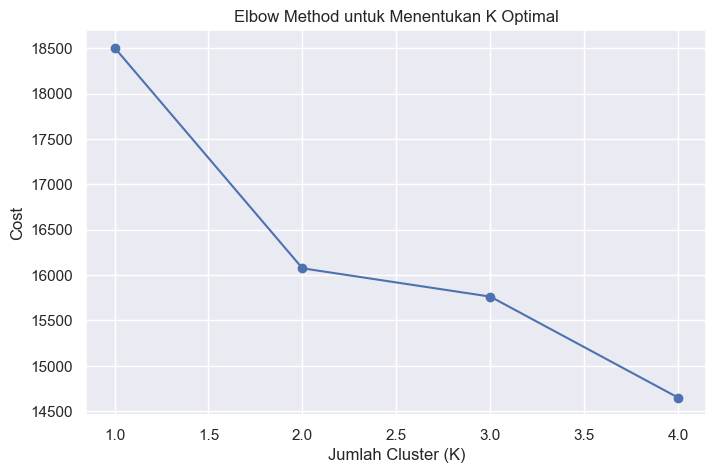


Data dengan Cluster Prediksi:
           job  marital  education default housing loan   contact month  \
0   unemployed  married    primary      no      no   no  cellular   oct   
1     services  married  secondary      no     yes  yes  cellular   may   
2   management   single   tertiary      no     yes   no  cellular   apr   
3   management  married   tertiary      no     yes  yes   unknown   jun   
4  blue-collar  married  secondary      no     yes   no   unknown   may   

  poutcome age_bin  cluster_predicted  
0  unknown   20-30                  0  
1  failure   30-40                  0  
2  failure   30-40                  1  
3  unknown   20-30                  0  
4  unknown   50-60                  0  


In [85]:
from kmodes.kmodes import KModes

# 1. Menjalankan K-Modes (Metode 'Cao')
km_cao = KModes(n_clusters=2, init="Cao", n_init=1, verbose=1)
fitClusters_cao = km_cao.fit_predict(bank_cust_encoded)

# 2. Mencari K Optimal dengan Elbow Method (Cost vs K)
# Membandingkan cost untuk K=1 sampai 4
cost = []
K_range = range(1, 5)
for num_clusters in K_range:
    kmode = KModes(n_clusters=num_clusters, init="Cao", n_init=1, verbose=0)
    kmode.fit_predict(bank_cust_encoded)
    cost.append(kmode.cost_)

# Plot Elbow
plt.figure(figsize=(8, 5))
plt.plot(K_range, cost, marker='o')
plt.xlabel('Jumlah Cluster (K)')
plt.ylabel('Cost')
plt.title('Elbow Method untuk Menentukan K Optimal')
plt.show()

# 3. Menggabungkan Hasil Prediksi ke Data Asli
bank_cust_copy['cluster_predicted'] = fitClusters_cao
print("\nData dengan Cluster Prediksi:")
print(bank_cust_copy.head())

### K-Modes - Visualisasi Profil Cluster

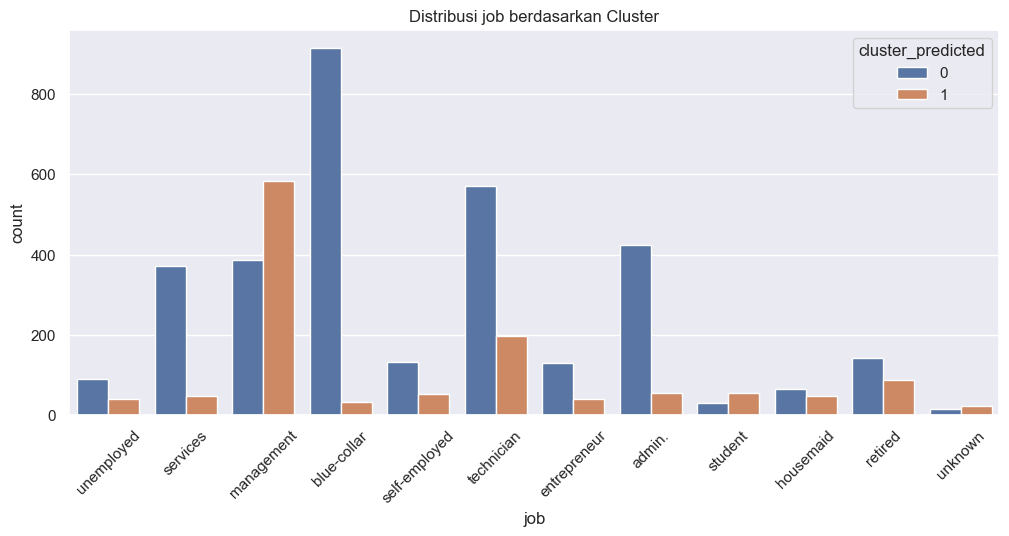

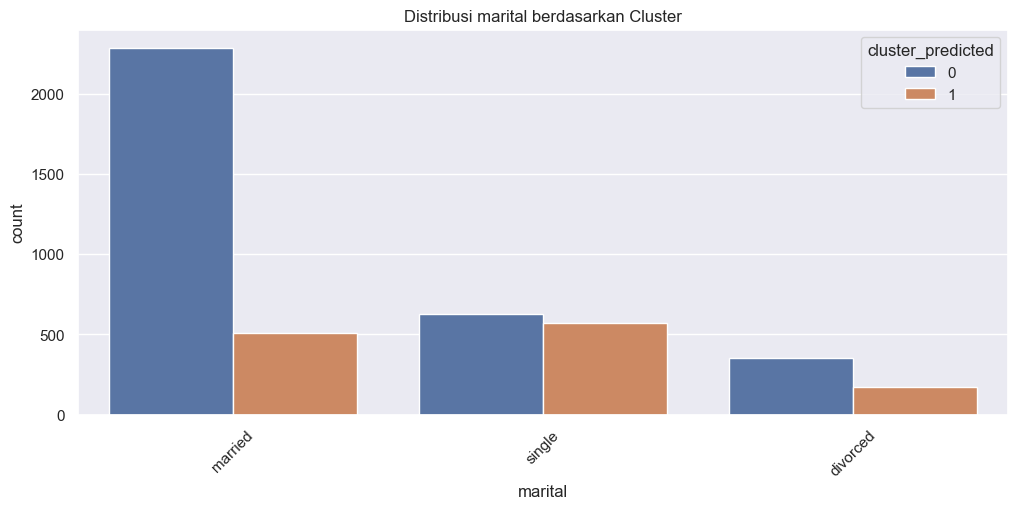

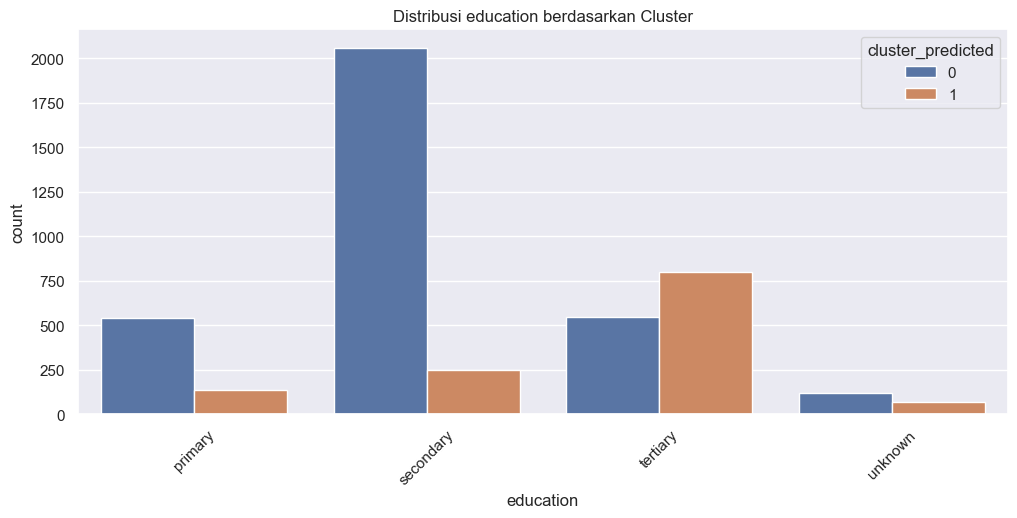

In [86]:
# Fungsi untuk visualisasi perbandingan cluster
def plot_cluster_comparison(col_name):
    plt.figure(figsize=(12, 5))
    sns.countplot(x=col_name, hue='cluster_predicted', data=bank_cust_copy)
    plt.title(f"Distribusi {col_name} berdasarkan Cluster")
    plt.xticks(rotation=45)
    plt.show()

# Visualisasi atribut penting
plot_cluster_comparison('job')
plot_cluster_comparison('marital')
plot_cluster_comparison('education')

### Hierarchical Clustering (Agglomerative)

In [ ]:
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering

# 1. Load Dataset German Credit
df_german = pd.read_csv("german_credit_data.csv")

# 2. quick look
print(df_german.shape, df_german.head(), df_german.info(), df_german.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
dtypes: int64(5), object(5)
memory usage: 78.3+ KB
(1000, 10)    Unnamed: 0  Age     Sex  Job Housing Saving accounts Checking account  \
0           0   67    male    2     own             NaN           little   
1           1   22  female    2     own          little         moderate   
2           2   49    male    1     own          lit

In [96]:
# 3. Missing values handling
print("Before handling missing values:\n", df_german.isnull().sum(), "\n")

numerical = ['Credit amount', 'Age', 'Duration']
categorical = ['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']
unused = ['Unnamed: 0']

# Drop unused column if it exists
df_german = df_german.drop(columns=unused, errors='ignore')
print("After dropping unused columns, shape:", df_german.shape)

# Drop rows that have NA in Saving accounts OR Checking account (as requested)
drop_subset = [c for c in ['Saving accounts', 'Checking account'] if c in df_german.columns]
if drop_subset:
    df_german = df_german.dropna(subset=drop_subset)
    print(f"Dropped rows with NA in {drop_subset}. New shape: {df_german.shape}")

# Fill remaining categorical NaNs with column mode (if available)
for cat in categorical:
    if cat in df_german.columns:
        mode_vals = df_german[cat].mode()
        if not mode_vals.empty:
            df_german[cat] = df_german[cat].fillna(mode_vals.iloc[0])
        else:
            # fallback fill if mode not available
            df_german[cat] = df_german[cat].fillna('missing')

print("\nAfter handling missing values:\n", df_german.isnull().sum())

Before handling missing values:
 Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
dtype: int64 

After dropping unused columns, shape: (522, 9)
Dropped rows with NA in ['Saving accounts', 'Checking account']. New shape: (522, 9)

After handling missing values:
 Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
dtype: int64


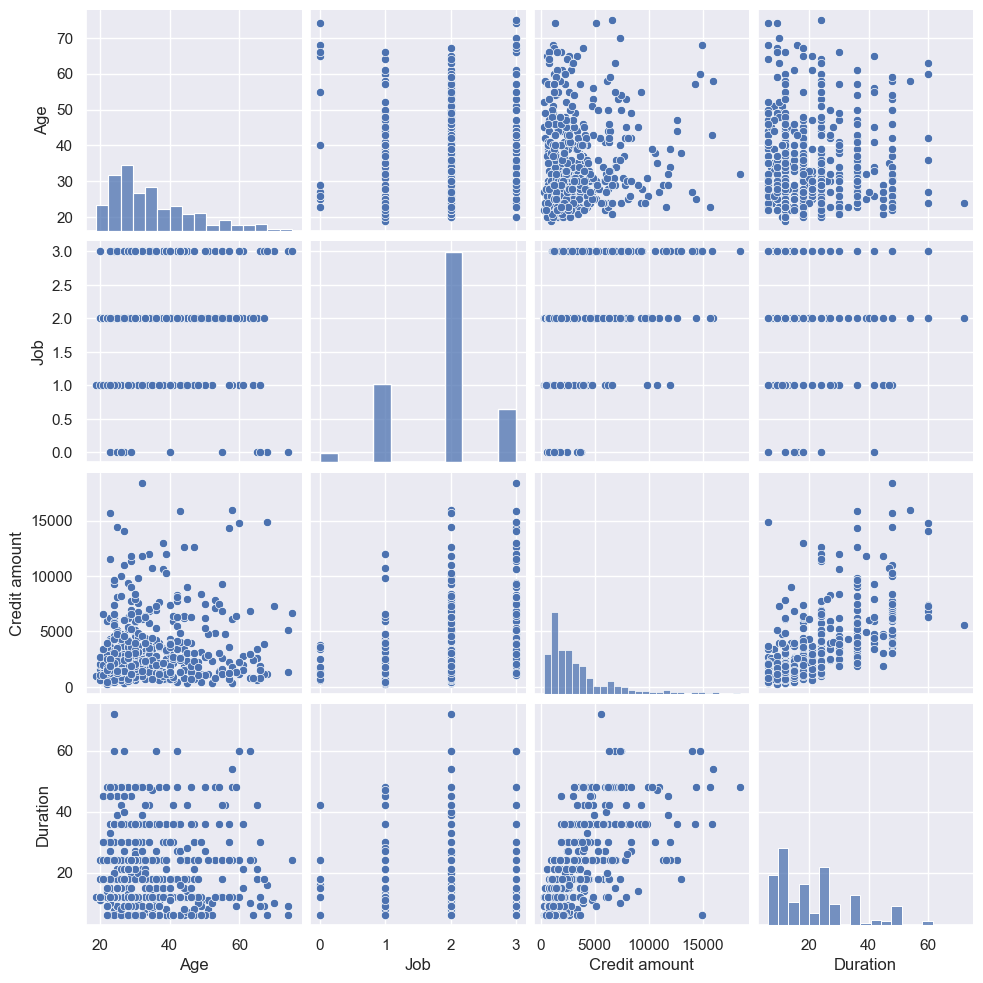

In [97]:
sns.pairplot(df_german)
plt.show()

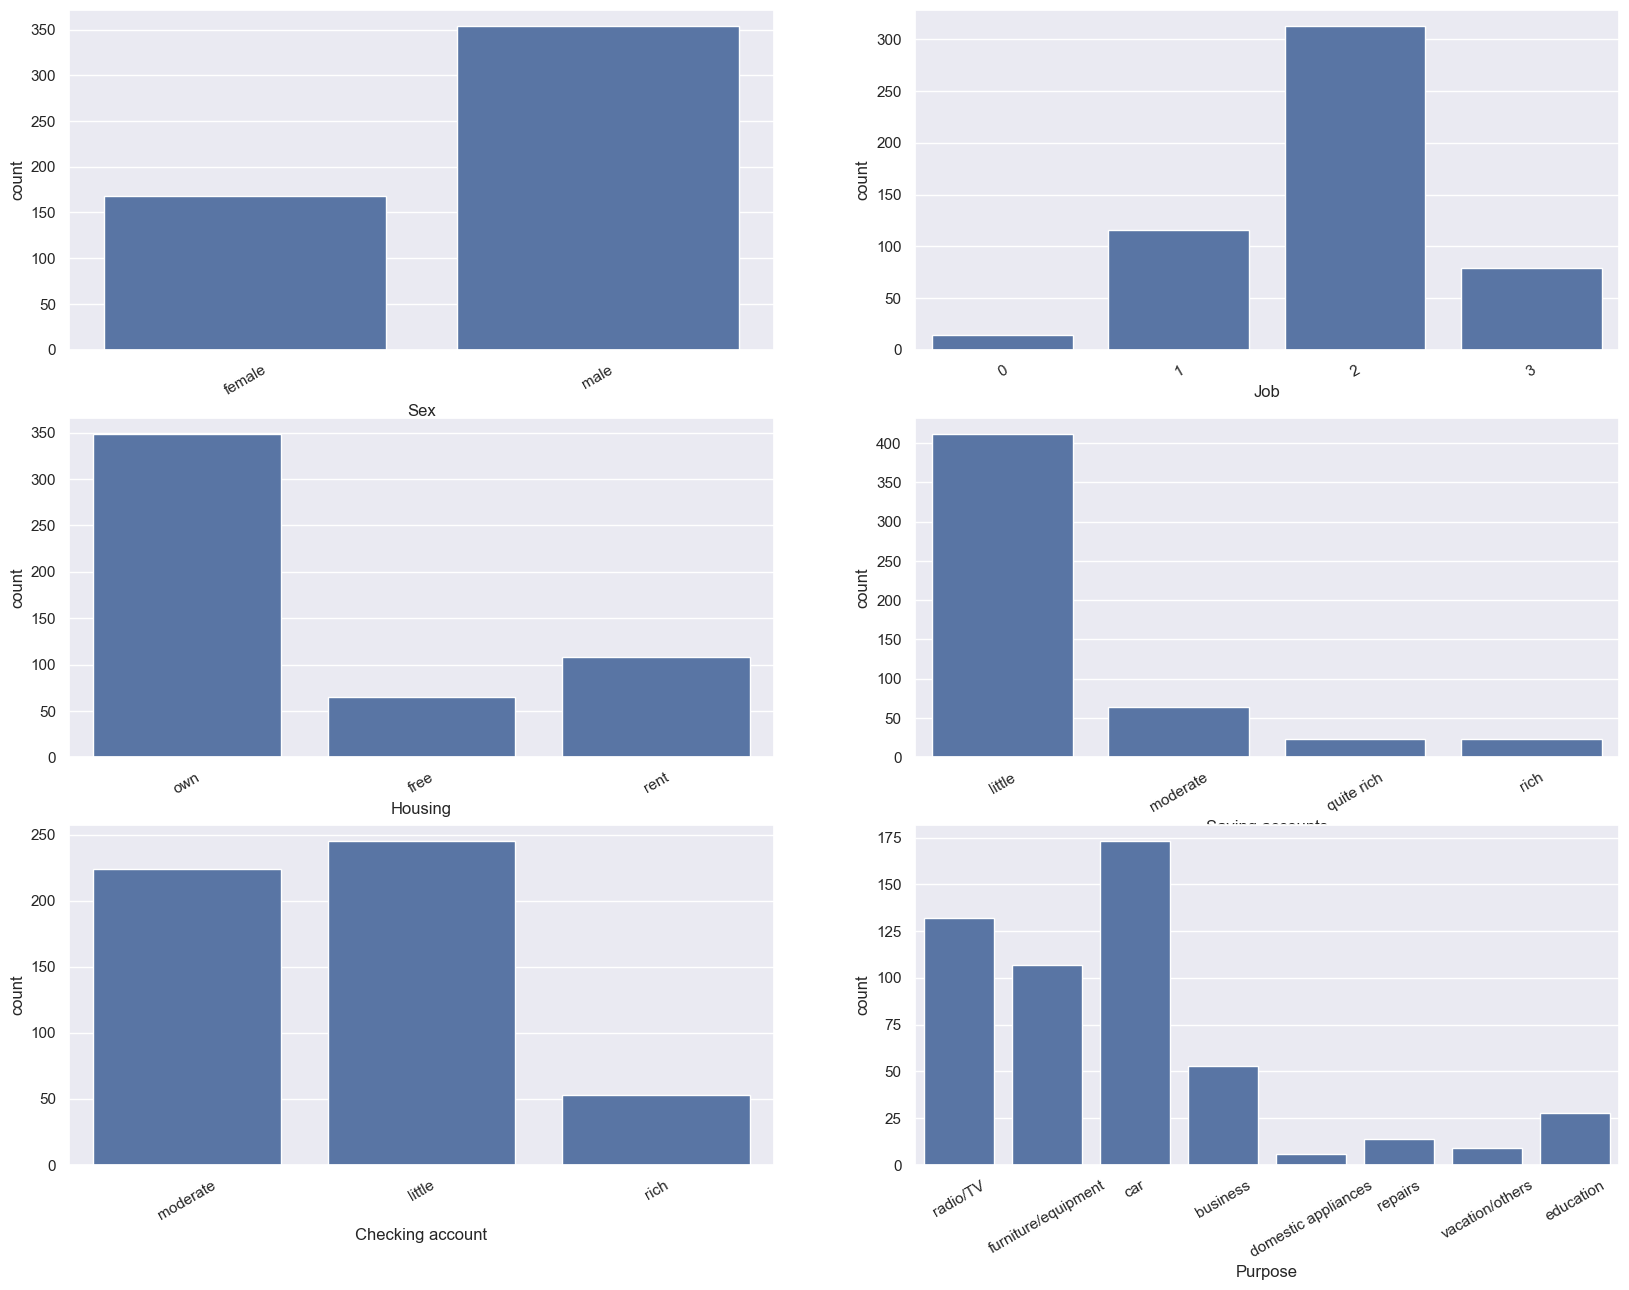

In [98]:
fig = plt.figure(figsize=(20,15))
axes = 320
for cat in categorical:
    axes +=1 
    fig.add_subplot(axes)
    sns.countplot(data = df_german, x = cat)
    plt.xticks(rotation=30)
plt.show()

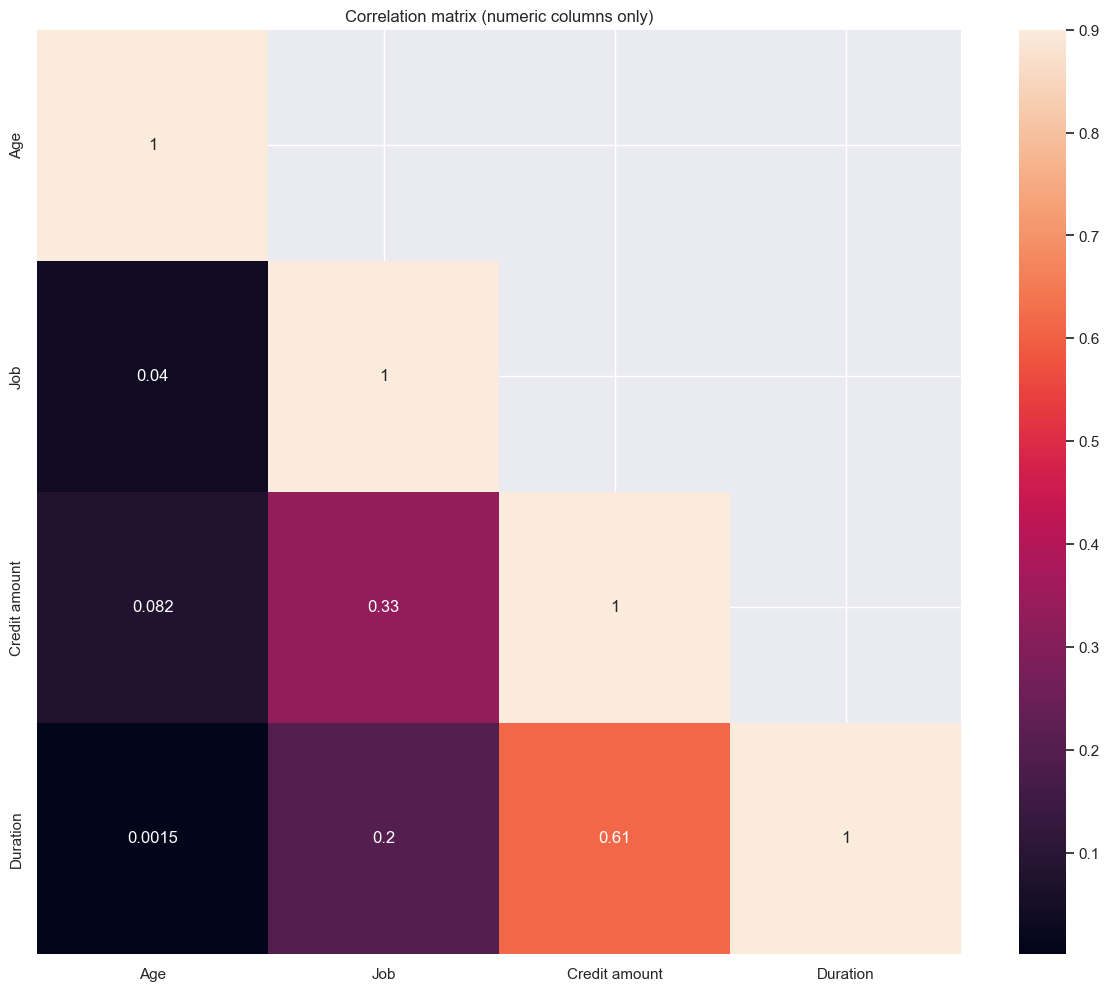

In [104]:
# Compute correlation only on numeric columns to avoid errors from categorical/text data
numeric_df = df_german.select_dtypes(include=[np.number])
if numeric_df.shape[1] == 0:
	raise ValueError("No numeric columns found in df_german to compute correlation.")

corr = numeric_df.corr(method='pearson')

# Mask the upper triangle (optional) to avoid duplicated information
mask = np.array(corr)
mask[np.tril_indices_from(mask)] = False
fig, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(corr, mask=mask, vmax=0.9, square=True, annot=True)
ax.set_title("Correlation matrix (numeric columns only)")
plt.show()

Output df_cluster.head():
   Credit amount  Age  Duration  Job
1           5951   22        48    2
3           7882   45        42    2
4           4870   53        24    2
7           6948   35        36    3
9           5234   28        30    3


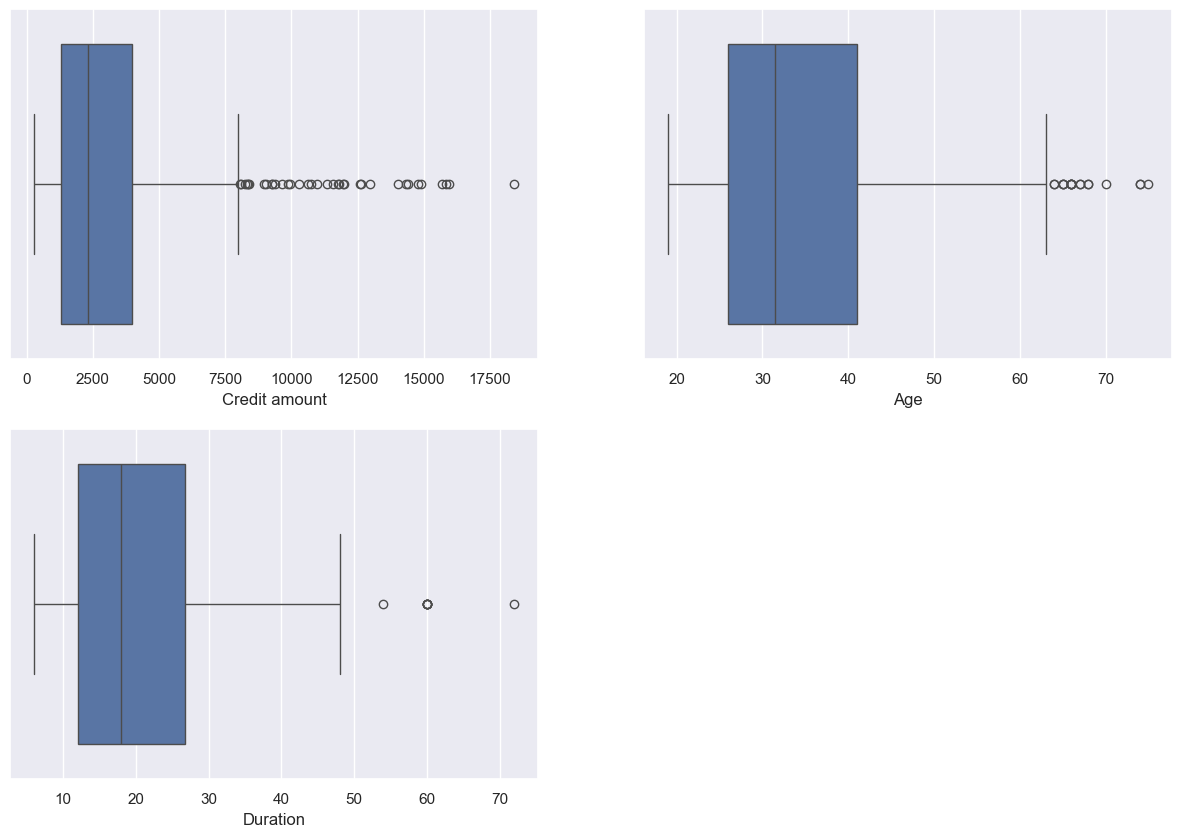

In [107]:
df = df_german
df_cluster = pd.DataFrame()
df_cluster['Credit amount'] = df['Credit amount']
df_cluster['Age'] = df['Age']
df_cluster['Duration'] = df['Duration']
df_cluster['Job'] = df['Job']

print("Output df_cluster.head():")
print(df_cluster.head())

fig = plt.figure(figsize = (15,10))
axes = 220 # Inisialisasi grid subplot (logika: 2 baris, 2 kolom)

for num in numerical:
    axes += 1
    fig.add_subplot(axes)
    sns.boxplot(data = df, x = num) # Membuat boxplot untuk setiap kolom numerik

plt.show()

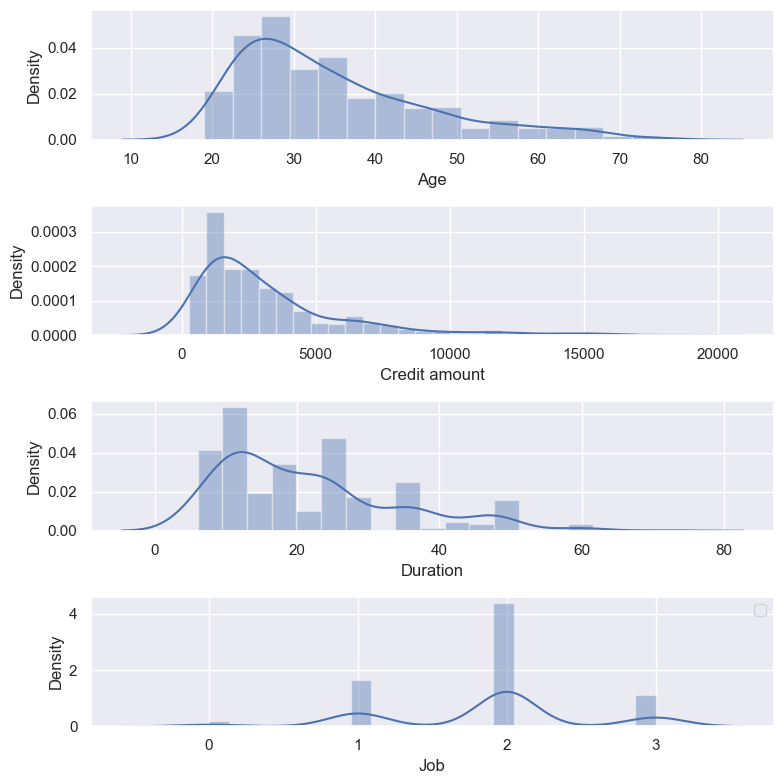

In [108]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(8, 8))

sns.distplot(df["Age"], ax=ax1)
sns.distplot(df["Credit amount"], ax=ax2)
sns.distplot(df["Duration"], ax=ax3)
sns.distplot(df["Job"], ax=ax4)

plt.tight_layout()
plt.legend()
plt.show()

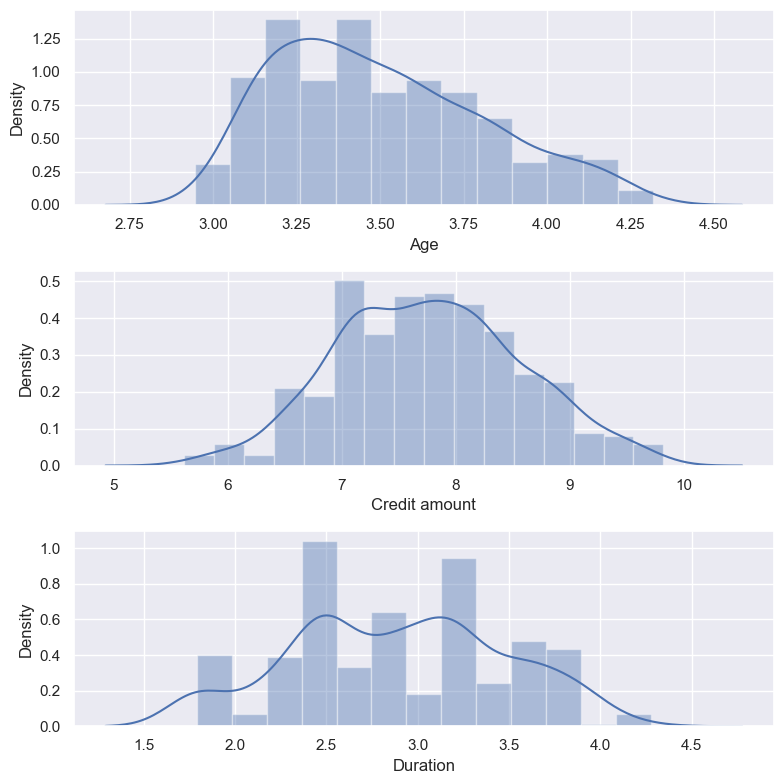

In [109]:
df_cluster_log = np.log(df_cluster[['Age', 'Credit amount', 'Duration']])

# Visualisasi hasil setelah transformasi log
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 8))

sns.distplot(df_cluster_log["Age"], ax=ax1)
sns.distplot(df_cluster_log["Credit amount"], ax=ax2)
sns.distplot(df_cluster_log["Duration"], ax=ax3)

plt.tight_layout()
plt.show()

        Age  Credit amount  Duration
1  3.091042       8.691315  3.871201
3  3.806662       8.972337  3.737670
4  3.970292       8.490849  3.178054
7  3.555348       8.846209  3.583519
9  3.332205       8.562931  3.401197


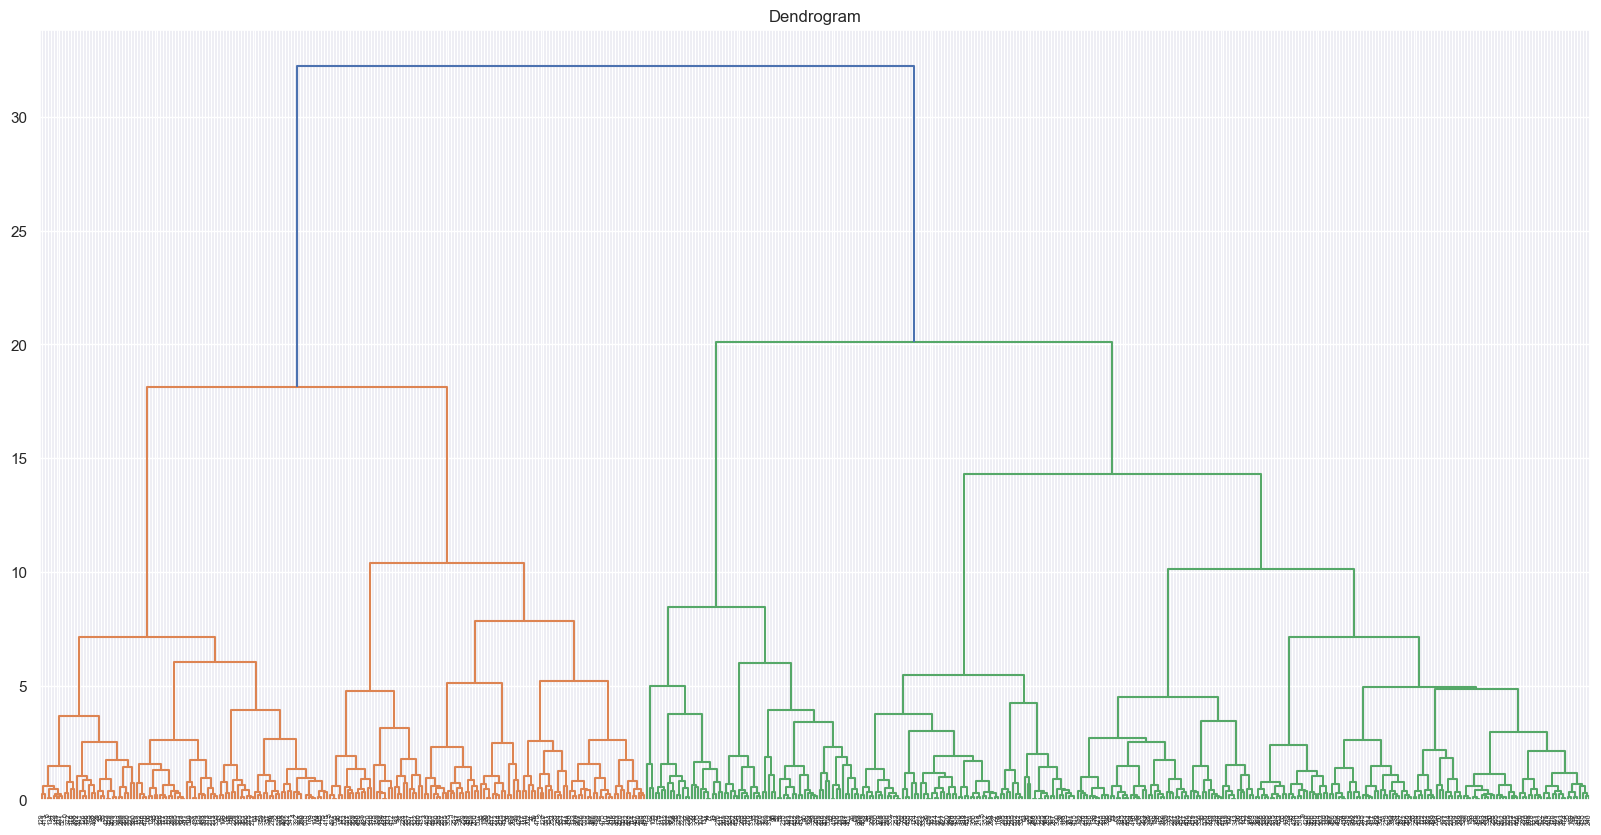

In [111]:
print(df_cluster_log.head())

from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

# --- 1. Scaling Data ---
# Menyamakan skala data agar jarak antar fitur seimbang
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(df_cluster_log)

# --- 2. Membuat Dendrogram ---
# Visualisasi hirarki clustering dengan metode 'ward'
plt.figure(figsize=(20, 10))
plt.title('Dendrogram') # Opsional: Menambahkan judul agar lebih jelas
dendrogram = sch.dendrogram(sch.linkage(cluster_scaled, method='ward'))
plt.show()

Hierarchical Agglomerative Clustering


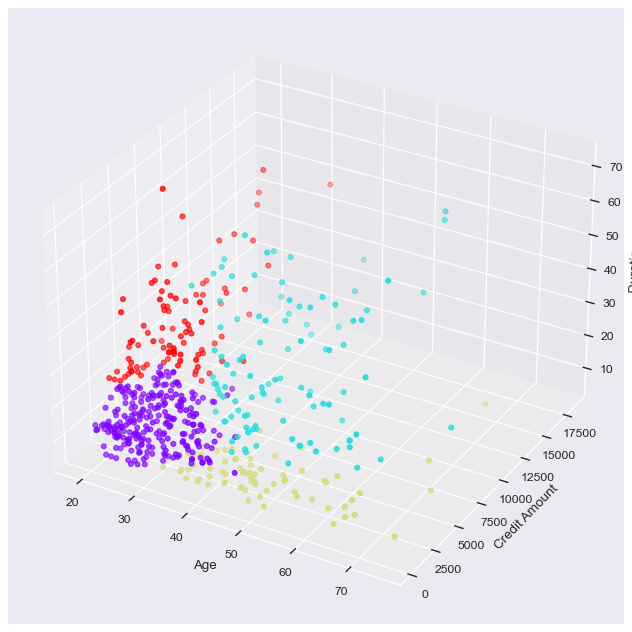

In [112]:
from sklearn.cluster import AgglomerativeClustering
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# 1. Menjalankan Model Agglomerative Clustering
model = AgglomerativeClustering(n_clusters=4)
model.fit(cluster_scaled)
hac_labels = model.labels_

# 2. Membuat Plot 3D (Sesuai Gambar)
fig = plt.figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
ax = plt.axes(projection="3d")

# Scatter plot 3D menggunakan data asli (df_cluster) untuk sumbu, dan label hasil cluster untuk warna
ax.scatter3D(df_cluster['Age'], df_cluster['Credit amount'], df_cluster['Duration'], 
             c=hac_labels, cmap='rainbow')

# Memberi label pada sumbu
xLabel = ax.set_xlabel('Age', linespacing=3.2)
yLabel = ax.set_ylabel('Credit Amount', linespacing=3.1)
zLabel = ax.set_zlabel('Duration', linespacing=3.4)

print("Hierarchical Agglomerative Clustering")
plt.show()

In [113]:
df_clustered_hac = df_cluster.assign(Cluster=hac_labels)
grouped_hac = df_clustered_hac.groupby(['Cluster']).mean().round(1)
print(grouped_hac)

         Credit amount   Age  Duration  Job
Cluster                                    
0               1913.8  28.7      15.2  1.8
1               5334.1  46.8      31.6  2.1
2               1876.6  49.3       9.3  1.8
3               5513.9  26.7      34.6  2.0


In [114]:
data = pd.read_csv('Wholesale_customers_data.csv')
data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


    Channel    Region     Fresh      Milk   Grocery    Frozen  \
0  0.000112  0.000168  0.708333  0.539874  0.422741  0.011965   
1  0.000125  0.000188  0.442198  0.614704  0.599540  0.110409   
2  0.000125  0.000187  0.396552  0.549792  0.479632  0.150119   
3  0.000065  0.000194  0.856837  0.077254  0.272650  0.413659   
4  0.000079  0.000119  0.895416  0.214203  0.284997  0.155010   

   Detergents_Paper  Delicassen  
0          0.149505    0.074809  
1          0.206342    0.111286  
2          0.219467    0.489619  
3          0.032749    0.115494  
4          0.070358    0.205294  


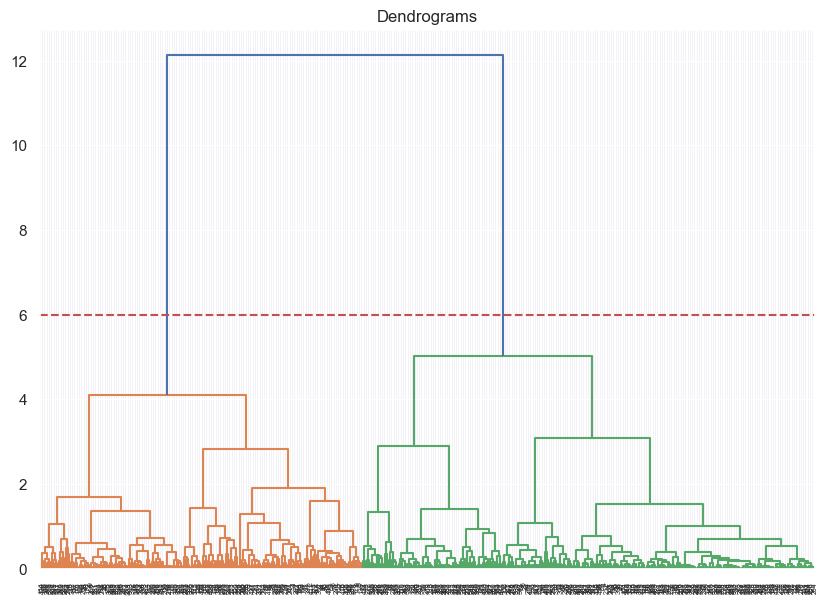

array([1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,

In [ ]:
from sklearn.preprocessing import normalize

# --- 1. Normalisasi Data ---
# Menormalkan data agar semua variabel memiliki skala yang sama
data_scaled = normalize(data)
data_scaled = pd.DataFrame(data_scaled, columns=data.columns)
print(data_scaled.head())

# --- 2. Membuat Dendrogram & Menentukan Threshold ---
plt.figure(figsize=(10, 7))
plt.title("Dendrograms")
# Membuat dendrogram dengan metode linkage 'ward' (shc was imported earlier in the notebook)
dend = shc.dendrogram(shc.linkage(data_scaled, method='ward'))

# Menambahkan garis horizontal (threshold) di y=6 untuk menentukan jumlah cluster
plt.axhline(y=6, color='r', linestyle='--')
plt.show()

# --- 3. Menerapkan Hierarchical Clustering ---
cluster = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='ward')
# Melakukan fit dan prediksi cluster
cluster.fit_predict(data_scaled)